---

### Задача 2.


Рассмотрим <a href="https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast">данные</a> о продажах 45 супермаркетов торговой сети Walmart с 2010 по 2012 годы. Датасет содержит 4 файла:
* `features.csv` &mdash; информация по неделям о средней температуре воздуха, цене на топливо, а также различная информация о рекламных акциях Walmart;

* `stores.csv` &mdash; информация о размере магазинов;

* `train.csv` &mdash; информация о недельных продажах для каждого отдела каждого магазина;

* `test.csv` &mdash; в данной задаче не требуется.

**Цель:** построить дизайн АБ-теста и ответить на вопрос, сколько магазинов потребуется для проведения AB-теста.

**Срок АБ-теста:** от 4 до 8 недель.

**Ожидаемый эффект:** +5% к прожадам магазина суммарно по всем отделам.

---

Нужно попробовать и сравнить разные подходы CUPED и стратификации, используя различные варианты дополнительных данных:
* без использования доп. данных, то есть простой t-test;
* данные о продажах предпериода, то есть стандартный CUPED;
* вещественные признаки, то есть CUPED при использовании различных ковариат;
* **[этот пункт можно сдать позже]** прогнозирование продаж с помощью различных моделей (CUPAC):
    * линейные модели;
    * градиентный бустинг;
    * нейронные сети.
    
Для построения нейронных сетей можно, например, использовать исторические данные продаж по разным отделам одного/нескольких магазинов для прогнозирования суммарной выручки за следующий период одного/нескольких магазинов. Можно дополнительно использовать другие признаки. Используйте любые подходящие архитектуры нейронных сетей.

*Внимание!* В данных представлено достаточно мало магазинов, поэтому честную валидацию скорее всего выполнить не получится. Используя имеющиеся данные требуется только как можно больше уменьшить дисперсию, которая участвует в формуле MDE.

Все, кроме применения различных моделей для прогноза, я уже сделал, так что тут будет только это

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm import trange
from datetime import datetime

from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

pd.options.mode.chained_assignment = None

In [52]:
train = pd.read_csv("train.csv", parse_dates=["Date"])
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [53]:
# Просуммируем все по департаментам

a = train.groupby(by=['Store', 'Date']).sum()
train = pd.DataFrame(a).reset_index().drop('Dept', axis=1)
train.IsHoliday /= 72
train.head()

,Store,Date,Weekly_Sales,IsHoliday
0,1,2010-02-05,1643690.90,0.0
1,1,2010-02-12,1641957.44,1.0
2,1,2010-02-19,1611968.17,0.0
3,1,2010-02-26,1409727.59,0.0
4,1,2010-03-05,1554806.68,0.0


In [6]:
features = pd.read_csv("features.csv", parse_dates=["Date"])
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.5 MB/s eta 0:00:00


In [8]:
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [23]:
# Как выглядит тренировочный датасет (это мы для каждого магазины приклеили еще его фичи, чтобы было на чем обучаться)

df = train[train.Store == 2].reset_index()
feat = features[features.Store ==  2][:143].reset_index().drop('IsHoliday', axis=1)
data = pd.concat((df, feat), axis = 1)
data = data.drop(['Store','Date'], axis=1)
data['date'] = np.arange(143) # Добавляем информацию про время
Y = data.Weekly_Sales
data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data.drop('Weekly_Sales', axis=1))
scaler = StandardScaler()
data[:-4] = scaler.fit_transform(data[:-4])
pd.DataFrame(data[:-4])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.719635,-0.278413,-1.719635,-1.793072,-1.491298,-0.027000,-0.004417,-0.007306,-0.022262,-0.013121,-1.114063,1.15595,-1.719635
1,-1.694712,3.580803,-1.694712,-1.901730,-1.547454,-0.027000,-0.004417,-0.007306,-0.022262,-0.013121,-1.079471,1.15595,-1.694712
2,-1.669790,-0.278413,-1.669790,-1.825030,-1.627010,-0.027000,-0.004417,-0.007306,-0.022262,-0.013121,-1.068248,1.15595,-1.669790
3,-1.644868,-0.278413,-1.644868,-1.415326,-1.517036,-0.027000,-0.004417,-0.007306,-0.022262,-0.013121,-1.060921,1.15595,-1.644868
4,-1.619946,-0.278413,-1.619946,-1.346935,-1.367285,-0.027000,-0.004417,-0.007306,-0.022262,-0.013121,-1.053593,1.15595,-1.619946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1.619946,-0.278413,1.619946,0.920181,1.002991,1.053877,-0.625106,-0.267326,1.845078,-0.527070,1.548128,-1.93271,1.619946
135,1.644868,3.527203,1.644868,1.240402,1.218258,-0.025239,-0.616053,-0.261223,-0.439287,-0.948781,1.579822,-1.93271,1.644868
136,1.669790,-0.278413,1.669790,0.488105,1.187840,-0.393220,-0.004417,-0.264869,-0.694435,0.770884,1.613769,-1.93271,1.669790
137,1.694712,-0.278413,1.694712,0.181946,1.197199,-0.648431,-0.633366,-0.268225,-0.879628,0.284908,1.661235,-1.93271,1.694712


In [24]:
# Получим предсказания бустингом и линейной регрессией

predictions_boosting = []
predictions_linreg = []
for store in trange(1, 46):
  df = train[train.Store == store].reset_index()
  feat = features[features.Store == store][:143].reset_index().drop('IsHoliday', axis=1)
  data = pd.concat((df, feat), axis = 1)
  data = data.drop(['Store', 'Date'], axis=1)
  data['date'] = np.arange(143) # Добавляем информацию про время
  Y = data.Weekly_Sales
  data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data.drop('Weekly_Sales', axis=1))
  scaler = StandardScaler()
  data[:-4] = scaler.fit_transform(data[:-4])
  data[-4:] = scaler.transform(data[-4:])
  model = GradientBoostingRegressor()
  model1 = LinearRegression()
  model.fit(data[:-4], Y[:-4])
  model1.fit(data[:-4], Y[:-4])
  predictions_boosting.append(model.predict(data[-4:]).mean())
  predictions_linreg.append(model1.predict(data[-4:]).mean())

100%|██████████| 45/45 [00:04<00:00, 10.03it/s]


In [26]:
# Смотрим на предсказания

list(zip(predictions_boosting, predictions_linreg))

[(1514319.909711359, 1563207.8212442112),
 (1805936.9849679365, 1804244.3810853828),
 (421802.0816585607, 419073.38584594434),
 (2070692.443778681, 2382262.0299604298),
 (314161.7210791517, 326981.7016241302),
 (1406139.0952147346, 1502991.8749496453),
 (607441.2430729145, 574779.1007738953),
 (1075865.8120891491, 931118.1540052192),
 (530273.4497815357, 530146.4540910462),
 (1742376.328756498, 1839572.551145665),
 (1305131.3875297338, 1343057.3154339585),
 (935658.5550437163, 1000020.3132913485),
 (2238026.780861497, 2137428.4736728217),
 (1583838.008058316, 1796857.9449761778),
 (573580.6678783069, 611851.8622658969),
 (483883.52894019004, 550969.8387573399),
 (1054934.239323868, 1021403.7916144913),
 (1053750.6808170923, 1044432.4770964393),
 (1358943.5023761038, 1408719.8354344396),
 (1972997.9656264938, 2147280.004183091),
 (681131.6838858842, 611449.8611814437),
 (966985.5608535123, 1026059.0758950851),
 (1448630.4060962806, 1437314.6731145447),
 (1263974.1060923068, 1369525.5787

Теперь пошла часть, которая уже была сделана когда-то давно. Оставляю ее, чтобы потом сравнить с новыми результатами

In [27]:
sample_size = 20  # Размер выборки, пока взял столько, потом посмотрим
n_iter = 10_000  # Количество итераций семплирования
alpha = 0.05  # Уровень значимости

lw = 5  # Толщина линий на графиках

In [28]:
def random_sampler(data, sample_size):
    '''
    Случайное семплирование двух групп одного размера из данных.
    
    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    '''
    
    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[sample_size:]

In [29]:
def draw_interval(
    real_alpha, left_alpha, right_alpha, 
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''
    
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2, 
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.
    
    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов
    
    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''
    
    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')
    
    return real_alpha, left_alpha, right_alpha

In [30]:
def cuped_ttest(
    x_data, y_data, 
    relative=True, cuped=True, paired=False, 
    sample_name='pilot', cuped_name='cuped', covariate_name='prepilot',  
    alpha=0.05
):    
    '''
    Относительный t-test.
    
    Аргументы:
    x, y -- выборки одинакового размера
    alpha -- уровень значимости
    :param relative: использовать относительный тест или абсолютный
    :param cuped: применять ли cuped
    :param paired: являются ли выборки парными
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    
    Возвращает:
    stat -- статистика критерия
    left_bound, right_bound -- границы дов. интервала
    pvalue
    '''
    
    assert len(x_data) == len(y_data)
    
    x_data = x_data.copy()
    x_data.index = range(len(x_data))
    y_data = y_data.copy()
    y_data.index = range(len(y_data))
    
    if cuped:
        # Сделаем cuped-преобразование
        x_data, y_data = cuped_transform(
            x_data, y_data, 
            sample_name=sample_name, 
            cuped_name=cuped_name, 
            covariate_name=covariate_name, 
            paired=paired
        )

    # Посчитаем все необходимые статистики
    x_mean = x_data.mean()
    y_mean = y_data.mean()
    x_mean_var = x_data.var(ddof=0) / len(x_data)
    y_mean_var = y_data.var(ddof=0) / len(y_data)
    xy_mean_var = (x_data - y_data).var(ddof=0) / len(y_data)
    
    # Имя столбца, которое будем использовать
    name = cuped_name if cuped else sample_name  
    
    if relative:
        # Случай относительного теста
        stat = (x_mean[name] - y_mean[name])/y_mean[sample_name]
        var = relative_ttest_var(
            mean1=x_mean[name]-y_mean[name], 
            mean2=y_mean[sample_name], 
            var1=xy_mean_var[name], 
            var2=y_mean_var[sample_name], 
            cov=np.cov(
                x_data[name]-y_data[name], 
                y_data[sample_name]
            )[0, 1] / len(x_data)
        )
            
    else:
        # Случай абсолютного теста
        stat = x_mean[name] - y_mean[name]
        var = simple_ttest_var(
            var1=x_mean_var[name], 
            var2=y_mean_var[name], 
            cov=np.cov(x_data[name], y_data[name])[0, 1] / len(x_data) if paired else 0
        )
    
    # По полученным значениям статистики и дисперсии применим
    # стандартные характеристики нормального распределения
    std = np.sqrt(var)
    z_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(z_stat))
    
    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std
    
    return stat, left_bound, right_bound, pvalue

In [31]:
def simple_ttest_var(var1, var2, cov):
    ''' Формула дисперсии абсолютного t-test '''
    
    return var1 + var2 - 2*cov


def relative_ttest_var(mean1, mean2, var1, var2, cov):
    ''' Формула дисперсии относительного t-test '''
    
    return var1 / mean2**2 \
        + var2 * mean1**2 / mean2**4 \
        - 2 * cov * mean1 / mean2**3

In [32]:
def AA_test(
    data=None, covariate_name=None, sample_name=None, cuped=True,
    n_iter=10000, sample_size=100, effect=0, relative_effect=True, alpha=0.05
):
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    data -- данные
    covariate_name -- имя столбца ковариаты
    sample_name -- имя столбца с целевыми данными
    cuped -- использовать ли CUPED
    n_iter -- количество итераций
    sample_size -- размер выборок
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теоретический уровень значимости
    '''


    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        x_data, y_data = random_sampler(data, sample_size)
        
        if relative_effect:
            x_data[sample_name] *= 1 + effect
        else:
            x_data[sample_name] += effect
        
        n_errors += cuped_ttest(
            x_data, y_data, relative=relative_effect, cuped=cuped,
            sample_name=sample_name, cuped_name='cuped', covariate_name=covariate_name,  
            alpha=alpha
        )[-1] < alpha

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

In [34]:
# Данные за последние 4 недели

data1 = train[(train['Date'] == '2012-10-26') | (train['Date'] == '2012-10-05') | 
            (train['Date'] == '2012-10-12') | (train['Date'] == '2012-10-19')]
a = data1.groupby(by=['Store'])['Weekly_Sales'].mean()
data1 = pd.DataFrame(a)
data1

,Weekly_Sales
Store,
1,1.561397e+06
2,1.895379e+06
3,4.210770e+05
4,2.147431e+06
5,3.253257e+05
6,1.461471e+06
7,5.053157e+05
8,9.239823e+05
9,5.642403e+05


100%|██████████| 10000/10000 [00:59<00:00, 167.94it/s]


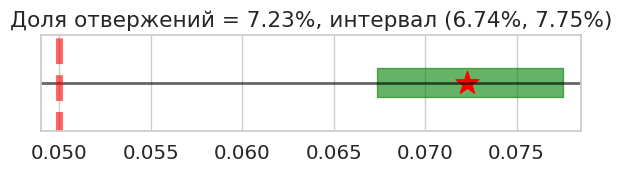

100%|██████████| 10000/10000 [01:17<00:00, 128.81it/s]


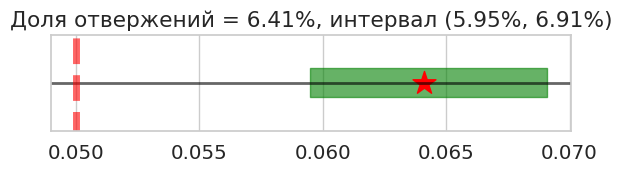

In [35]:
# Относительный t-test без дополнений

for effect in [0, 0.05]:
    AA_test(
        data=pd.DataFrame(data1['Weekly_Sales']), 
        covariate_name=None, 
        sample_name='Weekly_Sales', 
        cuped=False,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

Результаты очень печальные, будем пробовать со стандартным cuped, то есть с использованием данных предпериода

In [36]:
def cuped_transform(
    x_data, y_data, 
    sample_name='pilot', cuped_name='cuped', covariate_name='prepilot', 
    paired=False, return_theta=False
):
    '''
    Выполняет CUPED-преобразование.
    
    :param x_data: данные тестовой группы
    :param y_data: данные контрольной группы
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    '''
    
    # Случай парных выборок
    if paired:
        theta = (
            np.cov(
                x_data[covariate_name]-y_data[covariate_name], 
                x_data[sample_name]-y_data[sample_name]
            )[0, 1]
        ) / (
            (x_data[covariate_name] - y_data[covariate_name]).var(ddof=0)
        )

    # Случай независимых выборок
    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1] \
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0) + y_data[covariate_name].var(ddof=0)
        )
    
    # Делаем преобразование
    x_data[cuped_name] = x_data[sample_name] - theta*x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta*y_data[covariate_name]
    
    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

In [37]:
data2 = train[(train['Date'] == '2012-09-28') | (train['Date'] == '2012-09-21') | 
            (train['Date'] == '2012-09-14') | (train['Date'] == '2012-09-07')]
a = data2.groupby(by=['Store'])['Weekly_Sales'].mean()
data2 = pd.DataFrame(a)
data2

,Weekly_Sales
Store,
1,1.530595e+06
2,1.822367e+06
3,4.050060e+05
4,2.097505e+06
5,3.169745e+05
6,1.444495e+06
7,5.488462e+05
8,8.895627e+05
9,5.348394e+05


In [38]:
with_cuped = pd.concat((data1['Weekly_Sales'], data2['Weekly_Sales']), axis = 1)
with_cuped.columns = ['pilot', 'cuped']
with_cuped

,pilot,cuped
Store,,
1,1.561397e+06,1.530595e+06
2,1.895379e+06,1.822367e+06
3,4.210770e+05,4.050060e+05
4,2.147431e+06,2.097505e+06
5,3.253257e+05,3.169745e+05
6,1.461471e+06,1.444495e+06
7,5.053157e+05,5.488462e+05
8,9.239823e+05,8.895627e+05
9,5.642403e+05,5.348394e+05


100%|██████████| 10000/10000 [01:43<00:00, 96.30it/s]


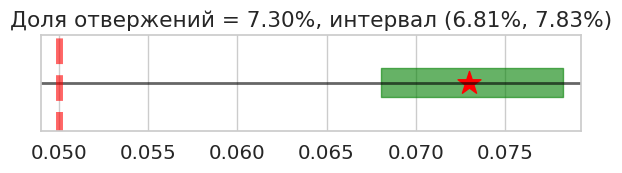

100%|██████████| 10000/10000 [01:34<00:00, 106.24it/s]


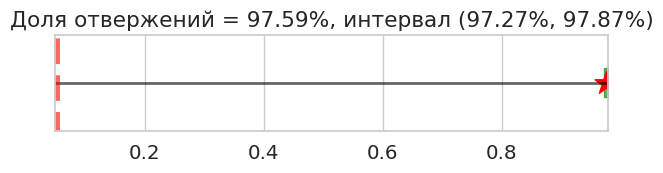

In [39]:
# Относительный t-test c cuped

for effect in [0, 0.05]:
    AA_test(
        data=with_cuped, 
        covariate_name='cuped', 
        sample_name='pilot', 
        cuped=True,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

C cuped на предпериоде уже очень высокая мощность для 20 магазинов. Попробуем снизить число магазинов в группе

100%|██████████| 10000/10000 [01:29<00:00, 112.26it/s]


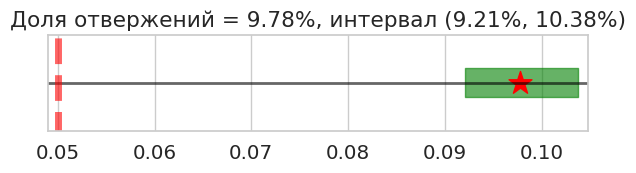

  0%|          | 28/10000 [00:00<01:13, 135.80it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 14%|█▍        | 1422/10000 [00:11<01:02, 137.28it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 24%|██▍       | 2400/10000 [00:18<00:53, 141.55it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 32%|███▏      | 3188/10000 [00:24<00:50, 135.19it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 57%|█████▋    | 5734/10000 [00:43<00:30, 140.59it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 96%|█████████▌| 9586/10000 [01:14<00:03, 134.98it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
100%|██████████| 10000/10000 [01:17<00:00,

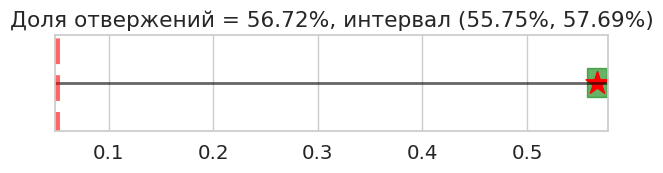

In [40]:
# Относительный t-test c cuped

sample_size = 10 # возьмем 10 магазинов

for effect in [0, 0.05]:
    AA_test(
        data=with_cuped, 
        covariate_name='cuped', 
        sample_name='pilot', 
        cuped=True,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

Запомним мощность для 10 магазинов с cuped на предпериоде, чтобы потом можно было сравнить

Теперь пойдет новая часть - cuped с предсказаниями моделей

Сначала смотрим для бустинга

In [41]:
with_cuped = pd.concat((data1['Weekly_Sales'], pd.DataFrame(predictions_boosting).set_index(np.arange(1,46))), axis = 1)
with_cuped.columns = ['pilot', 'cuped']
with_cuped.head()

,pilot,cuped
1,1.561397e+06,1.514320e+06
2,1.895379e+06,1.805937e+06
3,4.210770e+05,4.218021e+05
4,2.147431e+06,2.070692e+06
5,3.253257e+05,3.141617e+05


100%|██████████| 10000/10000 [01:14<00:00, 133.61it/s]


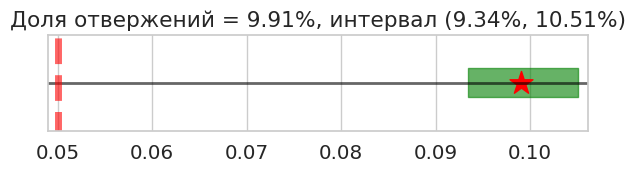

100%|██████████| 10000/10000 [01:16<00:00, 130.42it/s]


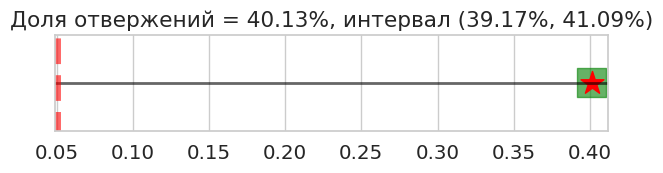

In [42]:
for effect in [0, 0.05]:
    AA_test(
        data=with_cuped, 
        covariate_name='cuped', 
        sample_name='pilot', 
        cuped=True,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

Чуть похуже получили, видимо, данных не очень много, чтобы бустинг получился лучше, чем просто данные на предпериоде

Теперь для линейной регрессии

In [43]:
with_cuped = pd.concat((data1['Weekly_Sales'], pd.DataFrame(predictions_linreg).set_index(np.arange(1,46))), axis = 1)
with_cuped.columns = ['pilot', 'cuped']
with_cuped.head()

,pilot,cuped
1,1.561397e+06,1.563208e+06
2,1.895379e+06,1.804244e+06
3,4.210770e+05,4.190734e+05
4,2.147431e+06,2.382262e+06
5,3.253257e+05,3.269817e+05


100%|██████████| 10000/10000 [01:32<00:00, 108.00it/s]


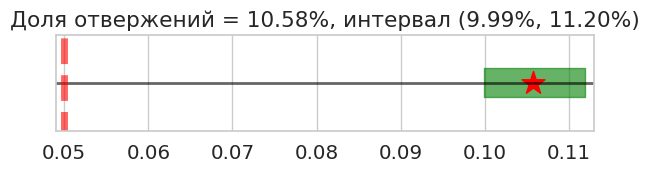

 88%|████████▊ | 8773/10000 [01:07<00:08, 140.12it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
 95%|█████████▍| 9457/10000 [01:13<00:03, 140.53it/s]<ipython-input-30-bfe273ca6422>:78: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
100%|██████████| 10000/10000 [01:17<00:00, 129.73it/s]


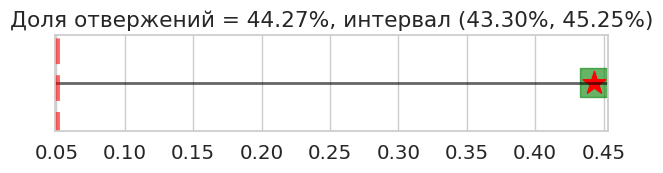

In [44]:
for effect in [0, 0.05]:
    AA_test(
        data=with_cuped, 
        covariate_name='cuped', 
        sample_name='pilot', 
        cuped=True,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

Чуть лучше, чем бустинг, но все еще хуже, чем на предпериоде. Осталось последнее - пробуем полносвязную нейросеть

In [45]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
%matplotlib inline

In [46]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [47]:
class MyDataset(torch.utils.data.Dataset):
    """
    Обернем наш датасет в такой класс для удобства
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.double), self.y[idx]]

In [58]:
def train_model(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
    '''
    train_overall = [] # лосс на трейне на каждой эпохе
    for epoch in range(10): # Ну путь будет столько эпох
        model.train()
        train_RMSE = [] # тут будут лоссы по батчам трейна (обновляется каждую эпоху)
        for batch in train_loader:
            x_train = batch[0]                              # Извлекаем данные и таргет из MyDataset (у нас же на нулевом месте
            y_train = batch[1]                              # в списке данные, а на первом - таргет)
            y_pred = model(x_train.float())         # Делаем предсказания
            loss = criterion(y_pred, y_train.float())        # Считаем лосс
            loss.backward()                                # Считаем градиенты
            optimizer.step()                               # Делаем шаг градиентного спуска
            optimizer.zero_grad()                          # Обнуляем градиенты
            with torch.no_grad():
                l = torch.mean((y_pred - y_train.float()) ** 2) # Вот тут мы считаем лосс
                train_RMSE.append(np.sqrt(l.numpy()))
                
        train_overall.append(np.mean(train_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
    return train_overall # будем возвращать лосс на трейне по эпохам, чтобы потом визуализировать 

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [113]:
predictions_NN = []
for store in trange(1, 46):
  df = train[train.Store == store].reset_index()
  feat = features[features.Store == store][:143].reset_index().drop('IsHoliday', axis=1)
  data = pd.concat((df, feat), axis = 1)
  data = data.drop(['Store', 'Date'], axis=1)
  data['date'] = np.arange(143) # Добавляем информацию про время
  Y = data.Weekly_Sales
  data = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data.drop('Weekly_Sales', axis=1))
  scaler = StandardScaler()
  data[:-4] = scaler.fit_transform(data[:-4])
  data[-4:] = scaler.transform(data[-4:])

  y_scaler = StandardScaler()
  y_train = y_scaler.fit_transform(np.array(Y[:-4]).reshape(-1, 1))
  y_test = y_scaler.transform(np.array(Y[-4:]).reshape(-1, 1))

  train_set = MyDataset(data[:-4], np.array(y_train))
  train_loader = torch.utils.data.DataLoader(train_set, 4, shuffle=False)
  test_set = MyDataset(data[-4:], np.array(y_test))
  test_loader = torch.utils.data.DataLoader(test_set, 4, shuffle=False)

  model0 = nn.Sequential(
      nn.Linear(data[:-4].shape[1], 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 256),
      nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1)
  )
  optimizer0 = torch.optim.Adam(model0.parameters(), lr = 0.0001)
  criterion0 = nn.MSELoss()

  train_model(model0, optimizer0, criterion0, train_loader, test_loader)
  for batch in test_loader:
      x = batch[0] 
      y = batch[1]
  predictions_NN.append(float(model0(x.float()).mean().detach().numpy() * y_scaler.scale_ + y_scaler.mean_))

100%|██████████| 45/45 [00:47<00:00,  1.05s/it]


In [114]:
predictions_NN

[1573385.2318903287,
 1923278.2057937605,
 394998.05720538803,
 2157472.253557386,
 322375.4253819662,
 1565075.9789878689,
 585996.3243996468,
 896988.6087687188,
 540507.4903577894,
 1921922.600384118,
 1350739.9494365666,
 996587.581615235,
 1962895.7156066769,
 2061453.3066778611,
 631375.7004758574,
 517258.5052338924,
 889706.142355474,
 1089884.8534678095,
 1424573.9486304251,
 2105815.275379336,
 762212.3449411776,
 1029768.9762337882,
 1415378.5481289772,
 1376501.6977184478,
 715696.220537961,
 981246.9192461657,
 1791802.1115397706,
 1309592.6053711036,
 541551.1984929314,
 439313.36708391295,
 1380383.080964338,
 1181106.8903320152,
 260019.3365017444,
 975728.6843278495,
 950813.9285685421,
 382575.9664172259,
 524427.4873384429,
 391712.09183222987,
 1436681.9292761926,
 968960.3261322454,
 1251715.6539717705,
 555324.6014473431,
 640990.0982698026,
 298797.50864632305,
 806920.90905248]

In [115]:
with_cuped = pd.concat((data1['Weekly_Sales'], pd.DataFrame(predictions_NN).set_index(np.arange(1,46))), axis = 1)
with_cuped.columns = ['pilot', 'cuped']
with_cuped.head()

,pilot,cuped
1,1.561397e+06,1.573385e+06
2,1.895379e+06,1.923278e+06
3,4.210770e+05,3.949981e+05
4,2.147431e+06,2.157472e+06
5,3.253257e+05,3.223754e+05


  0%|          | 0/10000 [00:00<?, ?it/s]

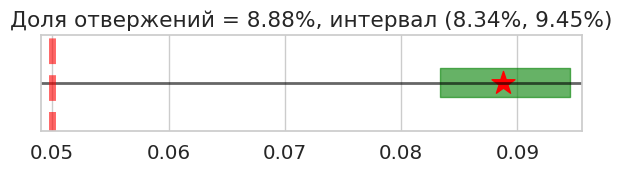

  0%|          | 0/10000 [00:00<?, ?it/s]

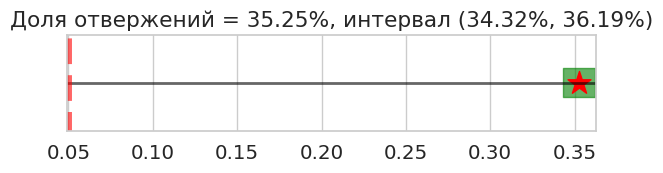

In [116]:
for effect in [0, 0.05]:
    AA_test(
        data=with_cuped, 
        covariate_name='cuped', 
        sample_name='pilot', 
        cuped=True,
        n_iter=n_iter, 
        sample_size=sample_size, 
        effect=effect
    )

Хуже всего вышло, но что поделать, я попробовал хотя бы

Поиск оптимального числа магазинов я производил в той домашке и получил 14 (все равно с предпериодом получилось лучше всего)